<h2> Load OGB data

In [2]:
from ogb.nodeproppred import PygNodePropPredDataset

<h2> Multigraph

In [323]:
from lib.tracing.utils import rel
import lib.agent as ag
from lib.tracing.network import get_random
n = 30
f1 = get_random(netsize=n, k=5)
f2 = get_random(netsize=n, k=5)
f3 = get_random(netsize=n, k=5)

In [327]:
rel(ag)
agent = ag.RecordAgent(measures=('eigenvector', 'DeepWalk:2', 'triangles'), record_edges=True)
f1.change_state(range(7), 'Ia')
agent.record_info(f1, net_changed=True)
f2.change_state(range(7), 'Ia')
agent.record_info(f2, net_changed=False)
agent.record_info(f3, net_changed=True)

In [328]:
d = agent.get_dataset(mark_delay_same_edges=False)
d

darda


[Data(edge_attr=[150, 2], edge_index=[2, 150], x=[30, 8], y=[30]),
 Data(edge_attr=[150, 2], edge_index=[2, 150], x=[30, 8], y=[30]),
 Data(edge_attr=[300, 2], edge_index=[2, 300], x=[30, 8], y=[30])]

In [164]:
import torch
import torch.multiprocessing as mp
import lib.untitled as module
from lib.tracing.utils import rel
rel(module)

def main(data):
    eng = module.Engine(data, numpy=False)
    num_processes = 2
    processes = []
    for rank in range(num_processes):
        p = mp.Process(target=eng)
        p.start()
        processes.append(p)
    for p in processes:
        p.join()
        
data = torch.zeros(10)
main(data)

In [161]:
data

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [192]:
from lib.model import GNNModel
from torch_geometric.data import DataLoader
train_loader = DataLoader(d, batch_size=4, shuffle=True)
gnn_model = GNNModel(d.num_node_features, d.num_classes if d.num_classes > 2 else 1)

In [193]:
item = next(iter(train_loader))
item

Batch(batch=[90], edge_attr=[900, 2], edge_index=[2, 900], ptr=[4], x=[90, 8], y=[90])

In [201]:
logits, emb = gnn_model(item.x, item.edge_index, item.batch)
# get predictions by thresholding
y_pred = (logits.squeeze(dim=-1) > 0).float()
# convert y to expected float type by the loss
y = item.y.float()
print('mse:', torch.mean((y_pred - item.y) ** 2))
crit = torch.nn.BCEWithLogitsLoss()
print('bce:', crit(y_pred, y))
print('acc:', ((y_pred == item.y).sum().float() / item.y.shape[0]))

mse: tensor(0.1778)
bce: tensor(0.7069)
acc: tensor(0.8222)


In [308]:
from copy import deepcopy
import torch.nn.functional as F
import networkx as nx

class TemporalMultiGraph():
    def __init__(self, agent, compute_target=True, use_dynamic_feat=False, use_inf_neigh=True):
        self.agent = agent
        self.compute_target = compute_target
        self.use_dynamic_feat = use_dynamic_feat
        self.use_inf_neigh = use_inf_neigh and agent.known_inf_neigh is not None
        self.cumm = None
        self.centr = None
        
    def combine_all(self, list_nx_or_edges):
        try:
            edges = list(nx_or_edgelist.edges(data=True))
        except AttributeError:
            edges = nx_or_edgelist
    
    def cummulative_and_last(self, net):
        y = torch.tensor(list(map(lambda x: x.startswith('I'), 
                                  net.node_states))).long() if self.compute_target else None
        last_data = get_dataset_from_network(
            net,
            x=self.get_features(net), 
            y=y,
            num_classes=2
        )
        last = last_data[0]
        last.edge_attr = F.pad(input=last.weight.reshape(-1,1), pad=(0, 1, 0, 0), mode='constant', value=0)
        
        if self.cumm is None:
            # if self.cumm doesn't exist, just initialize it to the latest network dataset
            self.cumm = deepcopy(last_data)
        else:
            # if this is reached, self.cumm is a GeometricDataset with one entry
            cumm = self.cumm[0]
            # we update in cumm the last entries for x and y
            cumm.x, cumm.y = last.x, last.y
            # edge_indexes get concatenated (i.e. multigraph)
            cumm.edge_index = torch.cat((cumm.edge_index, last.edge_index), dim=1)
            # we increase the edge attribute of time delay of interaction
            cumm.edge_attr[:, 1] += 1
            cumm.edge_attr = torch.cat((cumm.edge_attr, last.edge_attr), dim=0)
        return self.cumm, last_data
    
    def get_features(self, net, measures={'eigenvector','degree'}):
        agent = self.agent
        if agent.net_changed or self.centr is None:
            self.centr = torch.zeros(len(net), len(measures))
            for i, measure in enumerate(measures):
                try:
                    centr_dict = getattr(nx, measure + '_centrality')(net)
                except AttributeError:
                    centr_dict = getattr(nx, measure)(net)
                self.centr[:, i] = torch.tensor(list(centr_dict.values()))
        feats = [self.centr]
        if self.use_inf_neigh:
            feats.append(torch.tensor(list(agent.known_inf_neigh.values())))
        if self.use_dynamic_feat:
            feats.append(agent.dynamic_feat)
        # final result will be all features concatenated along columns
        return torch.cat(feats, dim=1)

In [309]:
import lib.agent as ag
from lib.tracing.network import get_random
n = 30
net = get_random(netsize=n, k=5)
agent = ag.Agent()
agent.known_inf_neigh = {i:(1,0) for i in range(n)}
agent.dynamic_feat = torch.zeros(n, 4)
graph = TemporalMultiGraph(agent, compute_target=True, use_dynamic_feat=True, use_inf_neigh=True)
for i in range(5):
    net.node_states[i] = 'Is'
    c, l = graph.cummulative_and_last(net)

In [ ]:
from timeit import timeit
import numpy as np
import torch

In [317]:
num_nodes = 1000
rankers = np.random.randn(num_nodes)
verify = 80
nodes = np.random.randint(0, num_nodes, size=verify)
lst = rankers.tolist()
tens = torch.tensor(lst)
tens_cuda = tens.cuda()
larg_k = 100

In [71]:
np.argsort(masked_rankers)[-larg_k:]

array([85, 87, 88, 90, 91, 92, 94, 95, 97, 99], dtype=int64)

In [72]:
np.sort(rankers[nodes])[-larg_k:]

array([0.98444677, 1.11935035, 1.12123741, 1.14552065, 1.1889801 ,
       1.26293688, 1.34861674, 1.35343968, 1.55119591, 1.77637607])

In [258]:
myown(nodes, rankers, larg_k)

[374, 110, 390, 247, 79, 239, 372, 129, 36, 99]

In [260]:
myown(nodes, list(rankers), larg_k)

[374, 110, 390, 247, 79, 239, 372, 129, 36, 99]

In [259]:
npown(nodes, rankers, larg_k)

array([374,  79, 239, 110,  36, 247, 129,  99, 372, 390], dtype=int64)

In [318]:
timeit(lambda: npown(nodes, tens.numpy(), larg_k), number=100000)

3.197808700002497

In [319]:
timeit(lambda: npown(nodes, tens.numpy(), larg_k), number=100000)

3.1728049000084866

In [320]:
timeit(lambda: myown(nodes, tens.numpy(), larg_k), number=100000)

5.833938100011437

In [322]:
timeit(lambda: myown(nodes, tens.numpy().tolist(), larg_k), number=100000)

6.654083700006595

In [321]:
timeit(lambda: myown(nodes, tens.numpy().tolist() if len(tens) < 500 else tens.numpy(), larg_k), number=100000)

6.207265500008361

In [ ]:
timeit(lambda: myown(nodes, list(tens), larg_k), number=100000)

In [266]:
timeit(lambda: myown(nodes, rankers, larg_k), number=100000)

5.30234309998923

In [272]:
timeit(lambda: myown(nodes, rankers.tolist(), larg_k), number=100000)

13.040164400008507

In [273]:
timeit(lambda: myown(nodes, list(rankers), larg_k), number=100000)

24.407063499995274

In [198]:
timeit(lambda: torchown(nodes, tens, larg_k), number=100000)

21.519074900003034

In [177]:
timeit(lambda: torchown(nodes, tens_cuda, larg_k), number=100000)

79.17722800000047

In [166]:
def myown(nodes, rankers, size):
    import heapq
    pq = []
    for nid in set(nodes):
        if len(pq) < size:
            heapq.heappush(pq, (rankers[nid], nid))
        else:
            heapq.heappushpop(pq, (rankers[nid], nid))
    return [entry[1] for entry in pq]

In [220]:
def npown(nodes, rankers, size):
    masked_rankers = rankers #np.asarray(rankers)
    mask = np.ones_like(rankers, dtype=bool)
    mask[np.unique(nodes)] = False
    masked_rankers[mask] = -1000
    return np.argpartition(masked_rankers, -larg_k)[-larg_k:]

In [176]:
def torchown(nodes, rankers, size):
    masked_rankers = rankers #torch.as_tensor(rankers)
    mask = torch.ones_like(masked_rankers, dtype=bool)
    mask[np.unique(nodes)] = False
    masked_rankers[mask] = -1000
    return torch.topk(masked_rankers, k=size, sorted=False)[1]

In [89]:
import lib.data as dat
from lib.tracing.utils import rel
rel(dat)
datum = dat.get_dataset_from_network(G)

In [90]:
datum[0]

Data(edge_index=[2, 4], route=[6], x=[2, 1])

In [93]:
datum[0].edge_index

tensor([[1, 1, 1, 1],
        [0, 2, 0, 2]])

In [94]:
datum[0].route

tensor([28, 37, 26, 28, 37, 26])

In [96]:
if [1,2,3] is all:
    print(2)

In [1]:
import networkx as nx
import lib.data as dat
F = nx.Graph()
F.add_edges_from([(0, 1, {"cash": 28}), (0, 2, {"cash": 37})])
dat1 = dat.get_dataset_from_network(F)
dat1[0]

Data(cash=[4], edge_index=[2, 4], x=[3, 1])

In [13]:
F.to_directed().edges

OutEdgeView([(0, 1), (0, 2), (1, 0), (2, 0)])

<h2> Use DNAConv

In [5]:
import os.path as osp

import torch
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import DNAConv

dataset = 'Cora'
path = osp.join('data', dataset)
dataset = Planetoid(path, dataset)
data = dataset[0]
data.train_mask = data.val_mask = data.test_mask = None


def gen_uniform_20_20_60_split(data):
    skf = StratifiedKFold(5, shuffle=True, random_state=55)
    idx = [torch.from_numpy(i) for _, i in skf.split(data.y, data.y)]
    data.train_idx = idx[0].to(torch.long)
    data.val_idx = idx[1].to(torch.long)
    data.test_idx = torch.cat(idx[2:], dim=0).to(torch.long)
    return data


data = gen_uniform_20_20_60_split(data)


In [10]:
class Net(torch.nn.Module):
    def __init__(self,
                 in_channels,
                 hidden_channels,
                 out_channels,
                 num_layers,
                 heads=1,
                 groups=1):
        super(Net, self).__init__()
        self.hidden_channels = hidden_channels
        self.lin1 = torch.nn.Linear(in_channels, hidden_channels)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers):
            self.convs.append(
                DNAConv(
                    hidden_channels, heads, groups, dropout=0.8, cached=True))
        self.lin2 = torch.nn.Linear(hidden_channels, out_channels)

    def reset_parameters(self):
        self.lin1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x, edge_index):
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x_all = x.view(-1, 1, self.hidden_channels)
        for conv in self.convs:
            x = F.relu(conv(x_all, edge_index))
            x = x.view(-1, 1, self.hidden_channels)
            x_all = torch.cat([x_all, x], dim=1)
        x = x_all[:, -1]
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return torch.log_softmax(x, dim=1)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(
    in_channels=dataset.num_features,
    hidden_channels=128,
    out_channels=dataset.num_classes,
    num_layers=5,
    heads=8,
    groups=16)
model, data = model.to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0005)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_idx], data.y[data.train_idx])
    loss.backward()
    optimizer.step()


def test():
    model.eval()
    logits, accs = model(data.x, data.edge_index), []
    for _, idx in data('train_idx', 'val_idx', 'test_idx'):
        pred = logits[idx].max(1)[1]
        acc = pred.eq(data.y[idx]).sum().item() / idx.numel()
        accs.append(acc)
    return accs

In [12]:
best_val_acc = test_acc = 0
for epoch in range(1, 20):
    train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(log.format(epoch, train_acc, best_val_acc, test_acc))

Epoch: 001, Train: 0.3026, Val: 0.3026, Test: 0.3011
Epoch: 002, Train: 0.3026, Val: 0.3026, Test: 0.3011
Epoch: 003, Train: 0.3026, Val: 0.3026, Test: 0.3011
Epoch: 004, Train: 0.3026, Val: 0.3026, Test: 0.3011
Epoch: 005, Train: 0.3026, Val: 0.3026, Test: 0.3011
Epoch: 006, Train: 0.3026, Val: 0.3026, Test: 0.3011
Epoch: 007, Train: 0.3026, Val: 0.3026, Test: 0.3011
Epoch: 008, Train: 0.3026, Val: 0.3026, Test: 0.3011
Epoch: 009, Train: 0.3026, Val: 0.3026, Test: 0.3011
Epoch: 010, Train: 0.3026, Val: 0.3026, Test: 0.3011
Epoch: 011, Train: 0.3026, Val: 0.3026, Test: 0.3011
Epoch: 012, Train: 0.3026, Val: 0.3026, Test: 0.3011
Epoch: 013, Train: 0.3026, Val: 0.3026, Test: 0.3011
Epoch: 014, Train: 0.3026, Val: 0.3026, Test: 0.3011
Epoch: 015, Train: 0.3026, Val: 0.3026, Test: 0.3011
Epoch: 016, Train: 0.3026, Val: 0.3026, Test: 0.3011
Epoch: 017, Train: 0.3026, Val: 0.3026, Test: 0.3011
Epoch: 018, Train: 0.3026, Val: 0.3026, Test: 0.3011
Epoch: 019, Train: 0.3026, Val: 0.3026, Test: 

<h2> Experiments with nx

In [20]:
%load_ext autoreload
%autoreload 2
import networkx as nx
from lib.tracing.network import get_random

Edges:  36


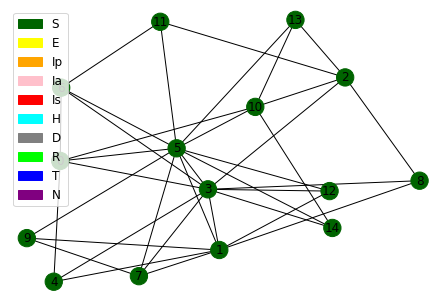

In [125]:
g = get_random(netsize=15, k=3, typ='powerlaw-cluster', p=0.2)
print('Edges: ', len(g.edges))
g.draw()

In [197]:
dict(nx.bfs_successors(g, 0, depth_limit=2))

{0: [3, 4, 5, 7, 8], 3: [1, 2, 6, 10, 13, 14], 4: [9, 11, 12]}

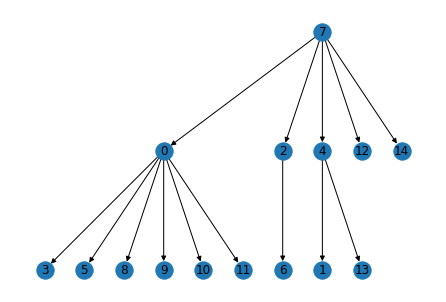

In [3]:
from networkx.drawing.nx_agraph import graphviz_layout
a = nx.bfs_tree(g, source=7, depth_limit=2)
pos = graphviz_layout(a, prog="dot")
nx.draw(a, pos, with_labels=True)

Edges:  36
[(0, 3), (0, 4), (0, 5), (0, 14), (1, 3), (1, 4), (1, 5), (1, 9), (1, 13), (2, 3), (2, 7), (2, 8), (2, 10), (2, 12), (3, 4), (3, 5), (3, 6), (3, 8), (3, 10), (3, 11), (3, 13), (3, 14), (4, 6), (4, 7), (4, 8), (4, 9), (4, 11), (5, 6), (5, 12), (5, 14), (6, 7), (6, 10), (8, 9), (8, 11), (8, 13), (10, 12)]


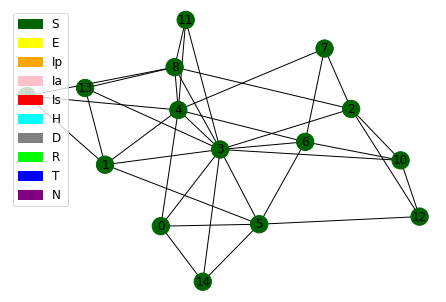

In [137]:
g = get_random(netsize=15, k=3, typ='powerlaw-cluster', p=0.2)
print('Edges: ', len(g.edges))
print(g.edges)
g.draw()

In [49]:
from pydoc import locate
dim=5
measure='Node2Vec'
embedder = locate(f'karateclub.{measure}')(dimensions=dim)
embedder.fit(g)
emb = embedder.get_embedding()
emb.shape

(15, 5)

In [138]:
from karateclub import Node2Vec
dw = Node2Vec(dimensions=5)
dw.fit(g)
print(len(g.edges))
emb = dw.get_embedding()
emb.shape

51


(15, 5)

In [136]:
g.edges

EdgeView([(0, 3), (0, 4), (0, 5), (0, 14), (0, 0), (1, 3), (1, 4), (1, 5), (1, 9), (1, 13), (1, 1), (2, 3), (2, 7), (2, 8), (2, 10), (2, 12), (2, 2), (3, 4), (3, 5), (3, 6), (3, 8), (3, 10), (3, 11), (3, 13), (3, 14), (3, 3), (4, 6), (4, 7), (4, 8), (4, 9), (4, 11), (4, 4), (5, 6), (5, 12), (5, 14), (5, 5), (6, 7), (6, 10), (6, 6), (7, 7), (8, 9), (8, 11), (8, 13), (8, 8), (9, 9), (10, 12), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14)])

In [28]:
from karateclub import GLEE
dw = GLEE(dimensions=5)
dw.fit(g)
emb = dw.get_embedding()
emb.shape

(15, 6)

In [40]:
import numpy as np
np.concatenate((np.zeros((15,2)), emb), axis=1).shape

(15, 7)

In [72]:
import numpy as np
import scipy
first = 'degree'
second = 'eigenvector'
scipy.stats.pearsonr(list(getattr(nx, first+'_centrality')(g).values()), list(getattr(nx, second+'_centrality')(g).values()))

(0.9358631144334866, 2.966707768941775e-07)

In [98]:
centrs = ('degree', 'closeness', 'harmonic', 'betweenness', 'load', 'eigenvector', 'current_flow_closeness', 'current_flow_betweenness', 'subgraph')
measures = ['pagerank', 'clustering', 'triangles', 'node_clique_number', 'greedy_color']
compare = [c+'_centrality' for c in centrs] + measures

# pears = [[scipy.stats.pearsonr(list(getattr(nx, c1)(g).values()), list(getattr(nx, c2)(g).values()))[0] for c1 in compare] for c2 in compare]
spear = [[scipy.stats.spearmanr(list(getattr(nx, c1)(g).values()), list(getattr(nx, c2)(g).values()))[0] for c1 in compare] for c2 in compare]

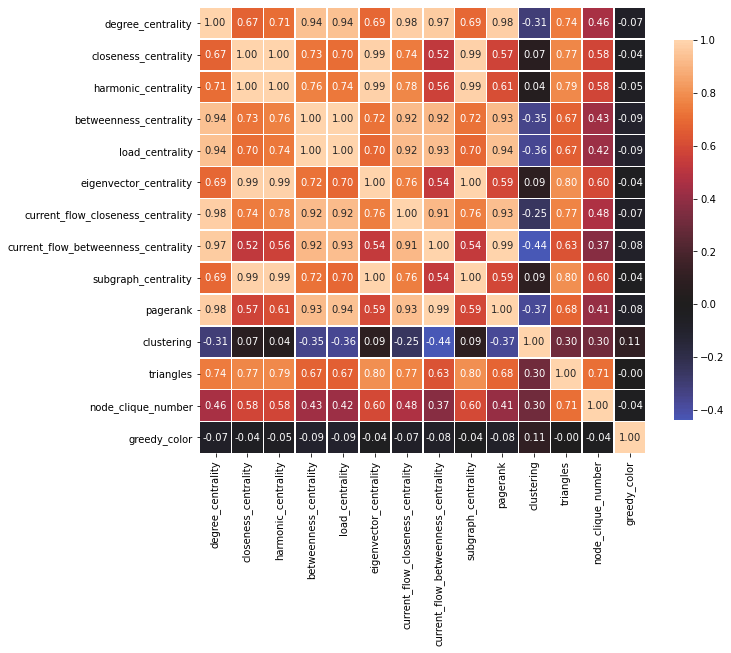

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt 

def correlation_heatmap(correlations, labels=None):
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', xticklabels=labels, yticklabels=labels,
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show()
    
correlation_heatmap(spear, labels=compare)

In [ ]:
correlation_heatmap(pears, labels=compare)

<h1> Tracing

In [64]:
import heapq
def control_both(net, nodes, size=3, **kwargs):
    # compute centralities
    centr = nx.current_flow_betweenness_centrality(net)
    # init priority queue (max heap needed, so negate the centrality measure since heapq uses min heap)
    pq = []
    for nid in nodes:
        if len(pq) < size:
            heapq.heappush(pq, (centr[nid], nid))
        else:
            heapq.heappushpop(pq, (centr[nid], nid))

    return [entry[1] for entry in pq]

control_both(g, (0,1,2,3,4,8))

[2, 0, 8]

In [5]:
# define network
import networkx as nx
from lib.tracing.network import get_random
seed = 11
g = get_random(netsize=500, k=5, typ='barabasi', nseed=0)
# g.draw(legend=False)
cl = nx.closeness_centrality(g)

In [1]:
from multiprocessing import cpu_count
cpu_count()

8

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import lib.run_tracing as run
import lib.agent as agent
import lib.tracing.multirun_engine as eng
from lib.tracing.utils import rel
rel(agent, run, eng)
ag = agent.CentralityAgent('eigenvector', tester=True, tracer=False, seed=7)
st = run.run_mock(agent=ag, nettype='powerlaw-cluster', netsize=500, k=6, isolate_s=False, first_inf=.1, presample=10000, pa=.2, \
                            p=.1, seed=11, rem_orphans=True, taut=0, taut_two=-1, delay_two=4, model='covid', netseed=4, \
                            multip=1, nnets=4, niters=4, dual=0, taur=0, noncomp=0, overlap_two=.7, noncomp_after=10000, 
                            uptake=.5, maintain_overlap=False, separate_traced=True, efforts=False, draw_fullname=True, 
                            draw=0, draw_iter=0, draw_layout='spring', sampling_type='min', nevents=0, trace_after=15,
                            summary_print=0, summary_splits=100, r_window=7, avg_without_earlystop=True)
st['res']['average-overall-infected']['mean']

Running simulation with parameters:
netsize = 500, k = 6, dual = 0, model = covid
overlap = 0.8, uptake = 0.5, maintain_overlap = False
taut = 0, taur = 0, noncomp = 0, noncomp_dependtime = True

----- Simulating network no. 0 -----
Iterations simulation progress:  50%|██████████████████████████                          | 2/4 [00:07<00:09,  4.73s/it]

In [3]:
import lib.agent as agent
ag = agent.Agent.from_dict(**dict(
    typ='centrality',
    measure='eigenvector', 
    tester=False, 
    tracer=False, 
    k_hops=2, 
    seed=8))

In [ ]:
import lib.run_tracing as run
st = run.run_mock(netsize=50, k=3, isolate_s=False, first_inf=.1, presample=10000, nettype='barabasi', pa=.5, \
                            p=.1, seed=2, rem_orphans=True, taut=.1, taut_two=-1, delay_two=4, model='covid', netseed=-1, \
                            multip=1, nnets=4, niters=4, dual=1, taur=0, noncomp=0.02, overlap_two=.7, noncomp_after=1000, 
                            uptake=.5, maintain_overlap=False, separate_traced=True, efforts=False, draw_fullname=True, 
                            draw=1, draw_iter=0, draw_layout='spring', sampling_type='min', nevents=0, trace_after=15,
                            summary_print=0, summary_splits=100, r_window=7, avg_without_earlystop=True, animate=0)

Running simulation with parameters:
netsize = 50, k = 3, dual = 1, model = covid
overlap = 0.8, uptake = 0.5, maintain_overlap = False
taut = 0.1, taur = 0, noncomp = 0.02, noncomp_dependtime = True

Networks simulation progress:  20%|██████████▊                                           | 1/5 [00:05<00:22,  5.64s/it]

In [5]:
import lib.run_tracing as run
# from lib.tracing.utils import rel
import lib.agent as agent
# rel(agent)
ag = dict(
    typ='centrality',
    measure='eigenvector', 
    tester=False, 
    tracer=False, 
    k_hops=2, 
    seed=8)
st = run.run_mock(agent=ag, nettype='powerlaw-cluster', netsize=800, k=6, isolate_s=False, first_inf=.1, presample=10000, pa=.2, \
                            p=.1, seed=11, rem_orphans=True, taut=0, taut_two=-1, delay_two=4, model='covid', netseed=4, \
                            multip=1, nnets=8, niters=4, dual=0, taur=0, noncomp=0, overlap_two=.7, noncomp_after=10000, 
                            uptake=.5, maintain_overlap=False, separate_traced=True, efforts=False, draw_fullname=True, 
                            draw=0, draw_iter=0, draw_layout='spring', sampling_type='min', nevents=0, trace_after=15,
                            summary_print=0, summary_splits=100, r_window=7, avg_without_earlystop=True)
st['res']['average-overall-infected']['mean']

Running simulation with parameters:
netsize = 800, k = 6, dual = 0, model = covid
overlap = 0.8, uptake = 0.5, maintain_overlap = False
taut = 0, taur = 0, noncomp = 0, noncomp_dependtime = True

Networks simulation progress: 100%|██████████████████████████████████████████████████████| 8/8 [00:37<00:00,  4.64s/it]


658.22

In [44]:
import lib.run_tracing as run
import lib.agent as agent
rel(agent)
ag = agent.CentralityAgent(measure='eigenvector', tester=True, tracer=False, k_hops=2, seed=8)
st = run.run_mock(agent=ag, nettype='powerlaw-cluster', netsize=500, k=6, isolate_s=False, first_inf=.1, presample=10000, pa=.2, \
                            p=.1, seed=11, rem_orphans=True, taut=0, taut_two=-1, delay_two=4, model='covid', netseed=4, \
                            multip=0, nnets=1, niters=10, dual=0, taur=0, noncomp=0, overlap_two=.7, noncomp_after=10000, 
                            uptake=.5, maintain_overlap=False, separate_traced=True, efforts=False, draw_fullname=True, 
                            draw=0, draw_iter=0, draw_layout='spring', sampling_type='min', nevents=0, trace_after=15,
                            summary_print=0, summary_splits=100, r_window=7, avg_without_earlystop=True)
st['res']['average-overall-infected']['mean']

Running simulation with parameters:
netsize = 500, k = 6, dual = 0, model = covid
overlap = 0.8, uptake = 0.5, maintain_overlap = False
taut = 0, taur = 0, noncomp = 0, noncomp_dependtime = True

----- Simulating network no. 0 -----
Running iteration 0:                                                                                                   
---> Result:309 total infected persons over time.                                                                      
Running iteration 1:                                                                                                   
---> Result:434 total infected persons over time.                                                                      
Running iteration 2:                                                                                                   
---> Result:485 total infected persons over time.                                                                      
Running iteration 3:                           

467.5

In [64]:
import heapq
mes = {1:4, 2:3, 3:2, 4:1}
nodes = mes.keys()
pq = []
size=2
for nid in set(nodes):
    if len(pq) < size:
        heapq.heappush(pq, (mes[nid], nid))
    else:
        heapq.heappushpop(pq, (mes[nid], nid))
pq

[(3, 2), (4, 1)]

In [65]:
a = [1,1,2,3,4,4,4,5]
from collections import Counter
Counter(a).most_common(3)

[(4, 3), (1, 2), (2, 1)]

In [1]:
import lib.run_tracing as run
import lib.agent as agent
from lib.tracing.utils import rel
rel(agent)
ag = agent.NeighborsAgent(measure='eigenvector', tester=True, tracer=False, n_test=10, n_trace=0, k_hops=1, seed=11)
st = run.run_mock(agent=ag, nettype='powerlaw-cluster', netsize=500, k=6, isolate_s=False, first_inf=.1, presample=10000, pa=.2,
                            p=.1, rem_orphans=True, taut=0, taut_two=-1, delay_two=4, model='covid',
                            multip=2, nnets=1, niters=2, dual=0, taur=0, noncomp=0, overlap_two=.7, noncomp_after=10000, 
                            uptake=.5, maintain_overlap=False, separate_traced=True, efforts=False, draw_fullname=True, 
                            draw=0, draw_iter=0, draw_layout='spring', sampling_type='min', nevents=0, trace_after=15,
                            summary_print=0, summary_splits=100, r_window=7, avg_without_earlystop=True,
                            seed=11, netseed=4, infseed=1)
st['res']['average-overall-infected']['mean']

Running simulation with parameters:
netsize = 500, k = 6, dual = 0, model = covid
overlap = 0.8, uptake = 0.5, maintain_overlap = False
taut = 0, taur = 0, noncomp = 0, noncomp_dependtime = True

----- Simulating network no. 0 -----
Iterations simulation progress: 100%|████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.19s/it]


375.0

In [29]:
import lib.run_tracing as run
import lib.agent as agent
from lib.tracing.utils import rel
rel(agent)
ag = agent.CentralityAgent(measure='eigenvector', tester=True, tracer=False, n_test=10, n_trace=0, k_hops=2, seed=11)
st = run.run_mock(agent=ag, nettype='powerlaw-cluster', netsize=500, k=6, isolate_s=False, first_inf=.1, presample=10000, pa=.2, \
                            p=.1, seed=11, rem_orphans=True, taut=0, taut_two=-1, delay_two=4, model='covid', netseed=4, \
                            multip=0, nnets=1, niters=10, dual=0, taur=0, noncomp=0, overlap_two=.7, noncomp_after=10000, 
                            uptake=.5, maintain_overlap=False, separate_traced=True, efforts=False, draw_fullname=True, 
                            draw=0, draw_iter=0, draw_layout='spring', sampling_type='min', nevents=0, trace_after=15,
                            summary_print=0, summary_splits=100, r_window=7, avg_without_earlystop=True)
st['res']['average-overall-infected']['mean']

Running simulation with parameters:
netsize = 500, k = 6, dual = 0, model = covid
overlap = 0.8, uptake = 0.5, maintain_overlap = False
taut = 0, taur = 0, noncomp = 0, noncomp_dependtime = True

----- Simulating network no. 0 -----
Running iteration 0:                                                                                                   
---> Result:362 total infected persons over time.                                                                      
Running iteration 1:                                                                                                   
---> Result:440 total infected persons over time.                                                                      
Running iteration 2:                                                                                                   
---> Result:432 total infected persons over time.                                                                      
Running iteration 3:                           

439.0

In [27]:
import lib.run_tracing as run
import lib.agent as agent
from lib.tracing.utils import rel
rel(agent)
ag = agent.CentralityAgent(measure='eigenvector', tester=False, tracer=False, n_test=10, n_trace=0, k_hops=2, seed=11)
st = run.run_mock(agent=ag, nettype='powerlaw-cluster', netsize=500, k=6, isolate_s=False, first_inf=.1, presample=10000, pa=.2, \
                            p=.1, seed=11, rem_orphans=True, taut=0, taut_two=-1, delay_two=4, model='covid', netseed=4, \
                            multip=0, nnets=1, niters=10, dual=0, taur=0, noncomp=0, overlap_two=.7, noncomp_after=10000, 
                            uptake=.5, maintain_overlap=False, separate_traced=True, efforts=False, draw_fullname=True, 
                            draw=0, draw_iter=0, draw_layout='spring', sampling_type='min', nevents=0, trace_after=15,
                            summary_print=0, summary_splits=100, r_window=7, avg_without_earlystop=True)
st['res']['average-overall-infected']['mean']

Running simulation with parameters:
netsize = 500, k = 6, dual = 0, model = covid
overlap = 0.8, uptake = 0.5, maintain_overlap = False
taut = 0, taur = 0, noncomp = 0, noncomp_dependtime = True

----- Simulating network no. 0 -----
Running iteration 0:                                                                                                   
---> Result:380 total infected persons over time.                                                                      
Running iteration 1:                                                                                                   
---> Result:460 total infected persons over time.                                                                      
Running iteration 2:                                                                                                   
---> Result:500 total infected persons over time.                                                                      
Running iteration 3:                           

466.3

In [154]:
import lib.run_tracing as run
import lib.agent as agent
rel(agent)
ag = agent.MixAgent('centrality', 'frequency', measure='eigenvector', tester=True, tracer=True, seed=7)
st = run.run_mock(agent=ag, nettype='powerlaw-cluster', netsize=500, k=6, isolate_s=False, first_inf=.1, presample=10000, pa=.2, \
                            p=.1, seed=11, rem_orphans=True, taut=0, taut_two=-1, delay_two=4, model='covid', netseed=4, \
                            multip=0, nnets=1, niters=10, dual=0, taur=0, noncomp=0, overlap_two=.7, noncomp_after=10000, 
                            uptake=.5, maintain_overlap=False, separate_traced=True, efforts=False, draw_fullname=True, 
                            draw=0, draw_iter=0, draw_layout='spring', sampling_type='min', nevents=0, trace_after=15,
                            summary_print=0, summary_splits=100, r_window=7, avg_without_earlystop=True)
st['res']['average-overall-infected']['mean']

Running simulation with parameters:
netsize = 500, k = 6, dual = 0, model = covid
overlap = 0.8, uptake = 0.5, maintain_overlap = False
taut = 0, taur = 0, noncomp = 0, noncomp_dependtime = True

----- Simulating network no. 0 -----
Running iteration 0:                                                                                                   
---> Result:338 total infected persons over time.                                                                      
Running iteration 1:                                                                                                   
---> Result:403 total infected persons over time.                                                                      
Running iteration 2:                                                                                                   
---> Result:438 total infected persons over time.                                                                      
Running iteration 3:                           

456.5

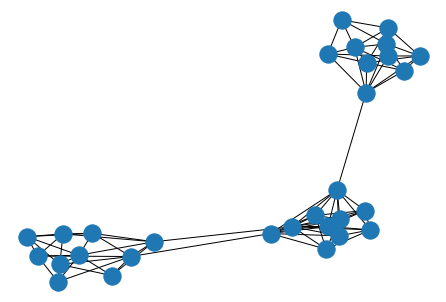

In [38]:
import networkx as nx
sizes = [10, 10, 10]
probs = [[0.75, 0.01, 0.01], [0.01, 0.65, 0.01], [0.01, 0.01, 0.70]]
g = nx.stochastic_block_model(sizes, probs, seed=0)
pos = nx.nx_agraph.graphviz_layout(g, prog="sfdp")
pos = nx.spring_layout(g)
nx.draw(g, pos=pos)

In [ ]:
import lib.run_tracing as run
import lib.agent as agent
%load_ext autoreload
%autoreload 2
from lib.tracing.utils import rel
import lib.tracing.network as net

rel(agent, run, net)
ag = agent.CentralityAgent(measure='degree', tester=True, tracer=False, k_hops=4, seed=8)
st = run.run_mock(agent=ag, nettype='sbm:2', netsize=30, k=12, isolate_s=False, first_inf=.1, presample=10000, pa=.2, \
                            p=.009, rem_orphans=True, taut=0, taut_two=-1, delay_two=4, model='covid',
                            multip=0, nnets=1, niters=10, dual=0, taur=0, noncomp=0, overlap_two=.7, noncomp_after=10000, 
                            uptake=.5, maintain_overlap=False, separate_traced=True, efforts=False, draw_fullname=True, 
                            draw=1, draw_iter=0, draw_layout='graphviz:neato', sampling_type='min', nevents=0, trace_after=15,
                            alpha_contain=.8, summary_print=0, summary_splits=100, r_window=7, avg_without_earlystop=True,
                            seed=14, netseed=13, infseed=4)
st['res']['average-overall-infected']['mean']

In [3]:
st['res']['average-%healthy']

{'mean': 0.2,
 'std': 0.87,
 'mean_wo': 0.2,
 'std_wo': 0.87,
 'whislo': 0.41,
 'q1': 0.31,
 'med': 0.19,
 'q3': 0.1,
 'whishi': 0.01,
 'whislo_wo': 0.41,
 'q1_wo': 0.31,
 'med_wo': 0.19,
 'q3_wo': 0.1,
 'whishi_wo': 0.01}